In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the dataset
def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

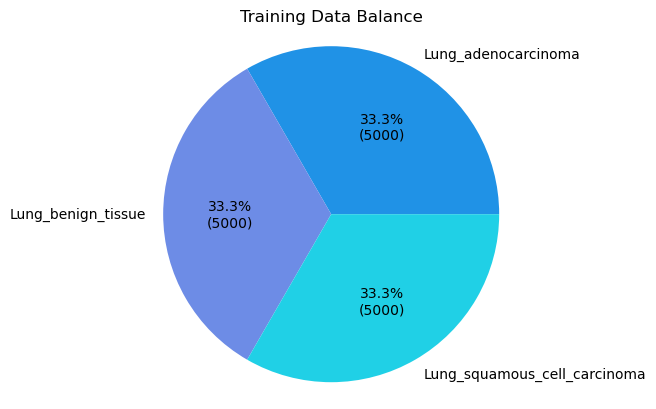

In [3]:
# Change label names to original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 
             'lung_n': 'Lung_benign_tissue', 
             'lung_scc': 'Lung_squamous_cell_carcinoma'}
    df[column_name] = df[column_name].replace(index)

# Load and preprocess data
data_dir = './lung_image_sets'
df = load_data(data_dir)
change_label_names(df, 'labels')

# Data Balance Pie Chart
data_balance = df.labels.value_counts()
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, 
        colors=["#2092E6", "#6D8CE6", "#20D0E6"])
plt.title("Training Data Balance")
plt.axis("equal")
plt.show()

In [4]:
# Data splitting: 80% training and 20% validation/test
train_df, ts_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=42)

# Data generators
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                      target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [5]:
# Model Building using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze some layers
for layer in base_model.layers[:-20]:  # Fine-tuning last 20 layers
    layer.trainable = False

# Model Architecture
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.005)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(len(train_gen.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)



In [6]:
# Train the model for exactly 5 epochs
epochs = 5
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False,
                    callbacks=[reduce_lr])


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 206s 534ms/step - accuracy: 0.7241 - loss: 1.4589 - val_accuracy: 0.7380 - val_loss: 1.2984 - learning_rate: 1.0000e-04
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 528ms/step - accuracy: 0.9060 - loss: 1.0976 - val_accuracy: 0.7887 - val_loss: 1.2281 - learning_rate: 1.0000e-04
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 197s 525ms/step - accuracy: 0.9350 - loss: 1.0038 - val_accuracy: 0.8807 - val_loss: 1.0541 - learning_rate: 1.0000e-04
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 529ms/step - accuracy: 0.9489 - loss: 0.9370 - val_accuracy: 0.9253 - val_loss: 0.9361 - learning_rate: 1.0000e-04
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 528ms/step - accuracy: 0.9623 - loss: 0.8789 - val_accuracy: 0.9393 - val_loss: 0.8732 - learning_rate: 1.0000e-04


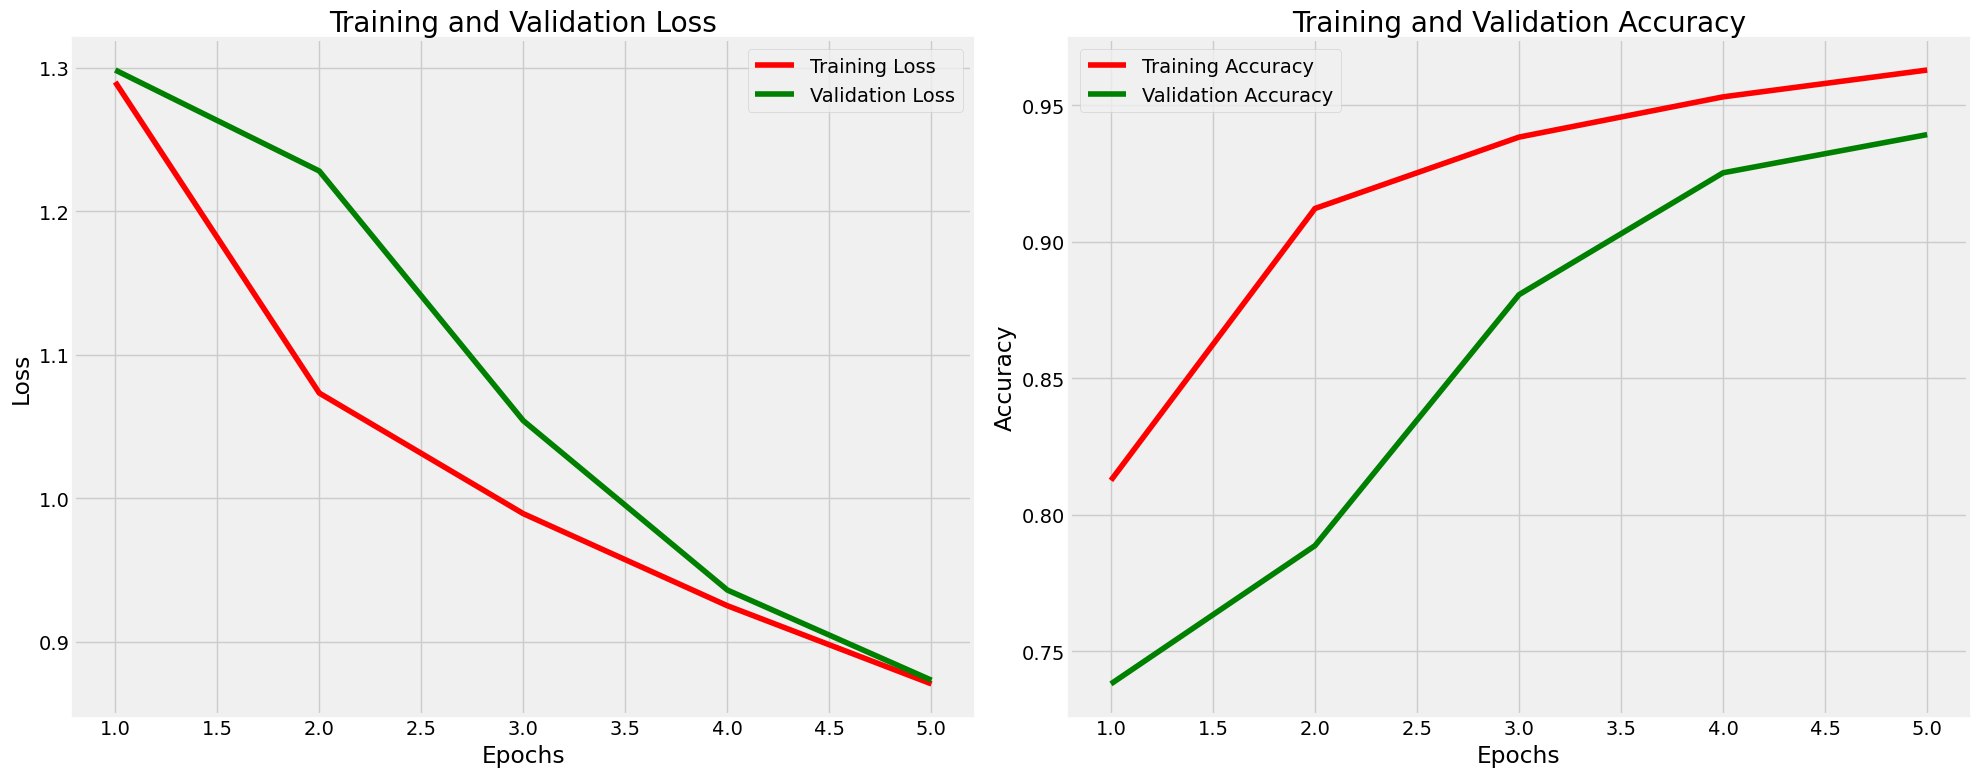

In [7]:
# Displaying the model performance
def model_performance(history):
    # Extract training history data
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    # Define the epochs for plotting
    Epochs = [i + 1 for i in range(len(tr_acc))]
    
    # Plot training and validation accuracy and loss
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    
    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

# Use this function after training to display the model's performance
model_performance(history)


In [8]:
# Evaluate the model on training, validation, and test sets
def model_evaluation(model):
    # Evaluate on training data
    train_score = model.evaluate(train_gen, verbose=1)
    # Evaluate on validation data
    valid_score = model.evaluate(valid_gen, verbose=1)
    # Evaluate on test data
    test_score = model.evaluate(test_gen, verbose=1)
    
    # Display the results
    print(f"Train Loss: {train_score[0]:.4f}")
    print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
    print('-' * 30)
    print(f"Validation Loss: {valid_score[0]:.4f}")
    print(f"Validation Accuracy: {valid_score[1] * 100:.2f}%")
    print('-' * 30)
    print(f"Test Loss: {test_score[0]:.4f}")
    print(f"Test Accuracy: {test_score[1] * 100:.2f}%")

# Use this function after training the model to evaluate its performance
model_evaluation(model)


375/375 ━━━━━━━━━━━━━━━━━━━━ 164s 437ms/step - accuracy: 0.9582 - loss: 0.8365
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.9384 - loss: 0.8768
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 582ms/step - accuracy: 0.9326 - loss: 0.8915
Train Loss: 0.8346
Train Accuracy: 95.82%
------------------------------
Validation Loss: 0.8732
Validation Accuracy: 93.93%
------------------------------
Test Loss: 0.8886
Test Accuracy: 93.40%


In [9]:
# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


In [11]:
# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step


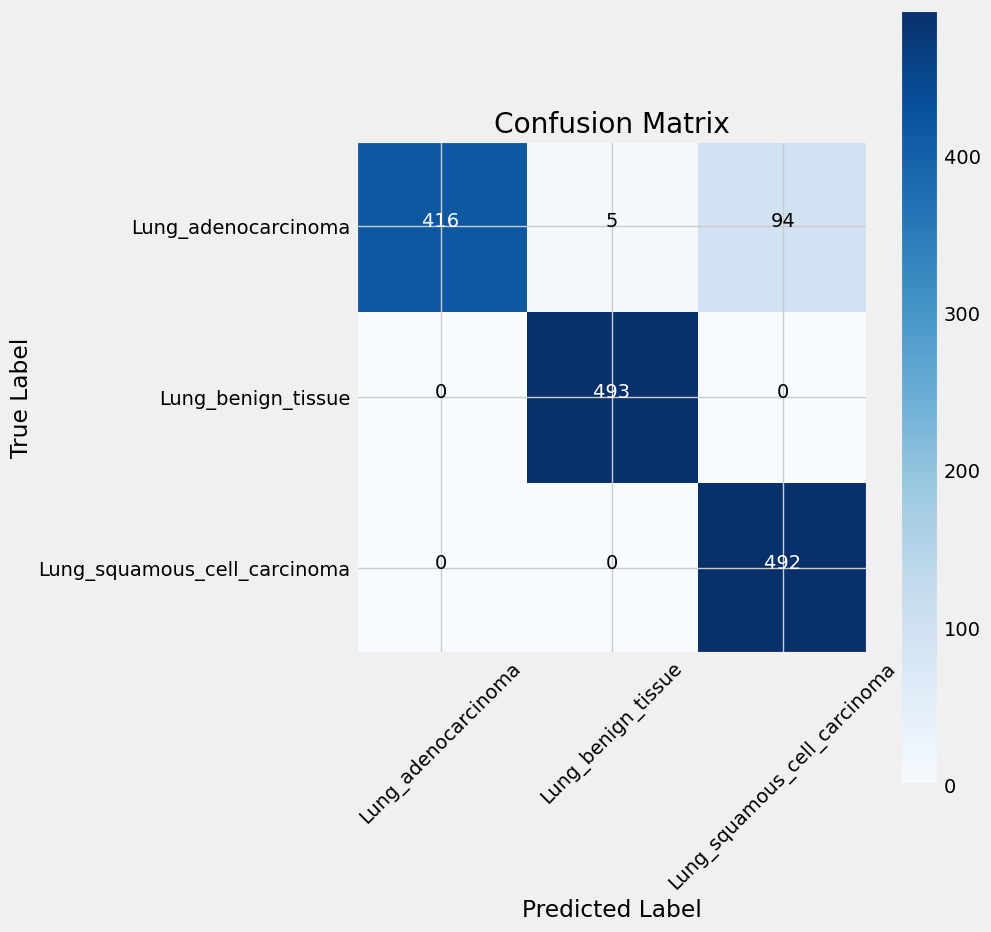

In [12]:
# Call the get_pred function to make predictions
y_pred = get_pred(model, test_gen)

# Call the plot_confusion_matrix function to plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

375/375 ━━━━━━━━━━━━━━━━━━━━ 161s 429ms/step


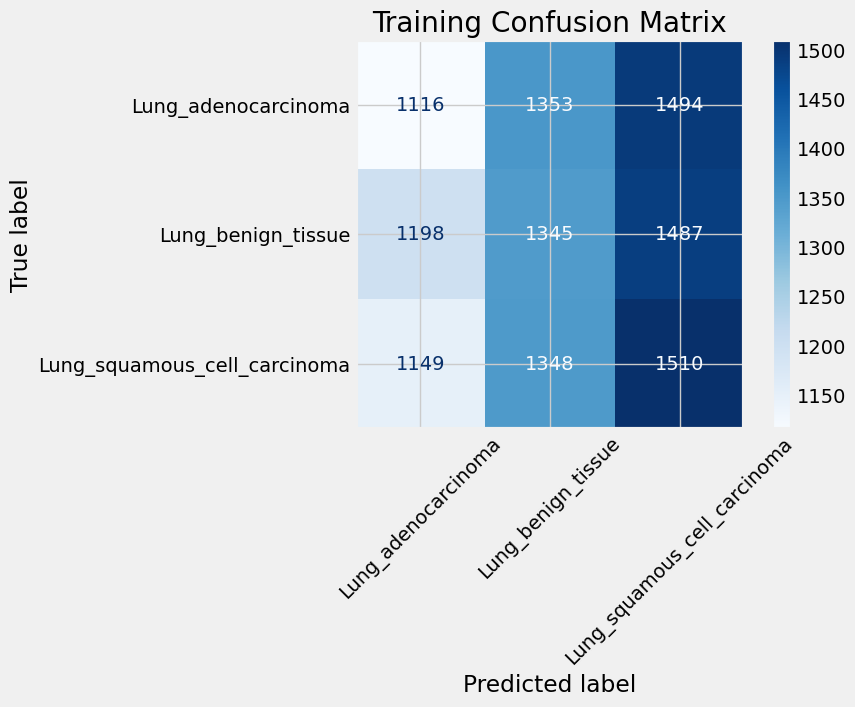

375/375 ━━━━━━━━━━━━━━━━━━━━ 161s 429ms/step


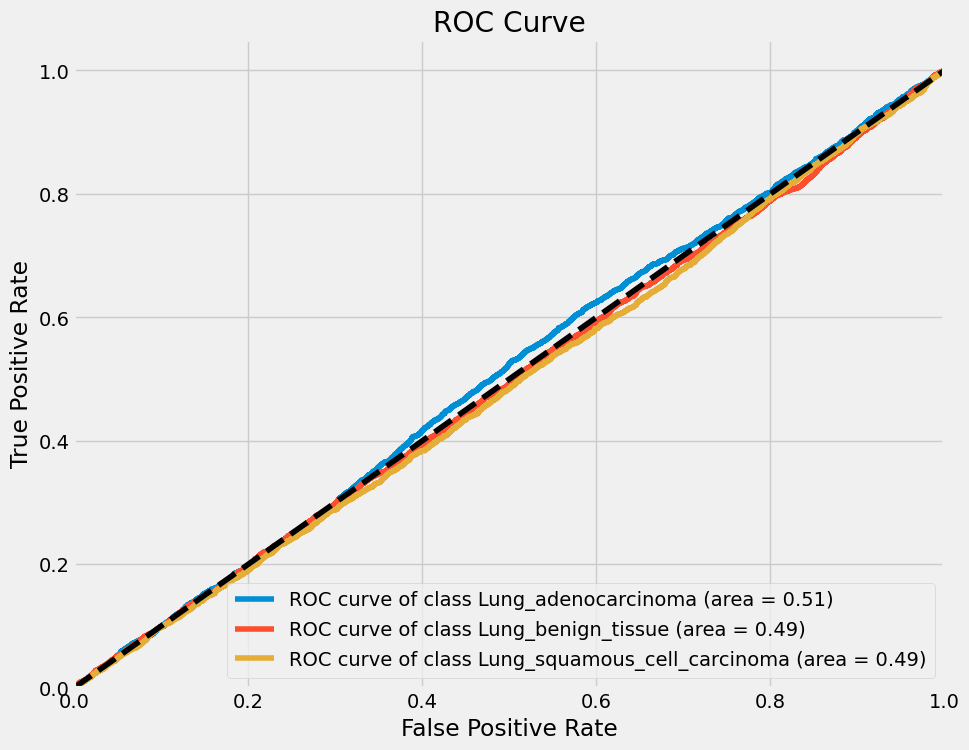

In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the training set
y_train_pred = get_pred(model, train_gen)

# True labels from the training generator
y_train_true = train_gen.classes

# Plot the training confusion matrix
def plot_training_confusion_matrix(train_gen, y_train_pred):
    # Get class names
    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_train_true, y_train_pred)
    
    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Training Confusion Matrix")
    plt.show()

# Call the function to plot the training confusion matrix
plot_training_confusion_matrix(train_gen, y_train_pred)


# ROC Curve Plotting Function
def plot_roc_curve(train_gen, model, data_gen):
    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    
    # Binarize the output
    y_true = label_binarize(train_gen.classes, classes=[0, 1, 2])  # Assuming 3 classes: Normal, SCC, Adenocarcinoma
    
    # Get predictions (probabilities)
    y_score = model.predict(data_gen)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot the ROC curve
plot_roc_curve(train_gen, model, train_gen)

